Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/7998b8a481fccd467463deb1fc46d19622079b0e/LICENSE.md)


# Building a scan programmatically for a regression use case

In this notebook we'll go through the end-to-end process of building a local model for a regression use case and running a Certifai Scan on said model to analyze Robustness, Fairness, Explainability, Explanation, and Perfomance. The models will be predicting the final settled claim amount for auto insurance claims.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import numpy as np
import random
import pprint

from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

from certifai.common.utils.encoding import CatEncoder
from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.scanner.explanation_utils import explanations

In [2]:
# Prepare datasets for test/train split
base_path = '..'
all_data_file = f"{base_path}/datasets/auto_insurance_claims_dataset.csv"
explanation_data_file = f"{base_path}/datasets/auto_insurance_explan.csv"
RANDOM_SEED = 42

df = pd.read_csv(all_data_file)

cat_columns = [
    'State Code',
    'Coverage',
    'Education',
    'EmploymentStatus',
    'Gender',
    'Location Code',
    'Marital Status',
    'Policy',
    'Claim Reason',
    'Sales Channel',
    'Vehicle Class',
    'Vehicle Size',
]
label_column = "Total Claim Amount"


Y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

encoder = CatEncoder(cat_columns, X)

# Train models

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'C':[0.1, .5, 1, 2, 4, 10], 'epsilon':[0, 0.01, 0.1, 0.5, 1, 2, 4]}
        m = LinearSVR()
    elif model_family == 'Lasso':
        parameters = {'alpha': [0.001,0.01,.1]}
        m = Lasso()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    r2 = r2_score(test[1], model.predict(test[0]))
    print(f"{name} R-Squared: {r2}")
    return model

linl1_model = build_model((encoder(X_train.values), Y_train),
                          "LinL1",
                          "Lasso",
                          (encoder(X_test.values), Y_test))


svm_model = build_model((encoder(X_train.values), Y_train),
                          "SVM",
                          "SVM",
                          (encoder(X_test.values), Y_test))

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4114486.086718209, tolerance: 41582.473948259176
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6142117.894511238, tolerance: 41650.022503835404
Objective did not converge. You might want to increase the number of iterations. Duality gap: 17083074.19811452, tolerance: 41791.14840787425
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4131730.180233203, tolerance: 41582.473948259176
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4007473.205419481, tolerance: 41650.022503835404
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4233819.213256873, tolerance: 41791.14840787425


LinL1 R-Squared: 0.7630312169777798
SVM R-Squared: 0.7458902350202914


In [3]:
# Wrap the models for use by Certifai as a local model
linl1_model_proxy = CertifaiPredictorWrapper(linl1_model, encoder=encoder)
svm_model_proxy = CertifaiPredictorWrapper(svm_model, encoder=encoder)

In [4]:
# Create the scan object from scratch using the ScanBuilder class

# Set the favorable direction to be increasing, and we'll consider
# a change of 0.5 standard deviations to be significant 
task = CertifaiPredictionTask(CertifaiTaskOutcomes.regression(True, 0.5),
                              prediction_description='Amount of Settled Claim')

scan = CertifaiScanBuilder.create('regression_test_use_case',
                                  prediction_task=task)

# Add our local models
first_model = CertifaiModel('LinL1', local_predictor=linl1_model_proxy)
scan.add_model(first_model)

second_model = CertifaiModel('SVM', local_predictor=svm_model_proxy)
scan.add_model(second_model)


# Add datasets to the scan
eval_dataset = CertifaiDataset('evaluation', CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)
scan.evaluation_dataset_id = eval_dataset.id

explan_dataset = CertifaiDataset('explanation', CertifaiDatasetSource.csv(explanation_data_file))
scan.add_dataset(explan_dataset)
scan.explanation_dataset_id = explan_dataset.id

# Here we are using a dataframe (from our test/train split) instead of a CSV file for the performance evaluation
test_df = pd.concat([X_test, Y_test], axis=1)
test_dataset = CertifaiDataset('test', CertifaiDatasetSource.dataframe(test_df))
scan.add_dataset(test_dataset)
scan.test_dataset_id = test_dataset.id

# Because the datasets contain a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'Total Claim Amount'


# Setup an evaluation that includes Robustness, Explainability, Explanations, Fairness and Performance
scan.add_evaluation_type('robustness')
scan.add_evaluation_type('explainability')
scan.add_evaluation_type('explanation')

# We'll look at disparity between groups defined by Marital Status and Gender in the fairness evaluation
scan.add_evaluation_type('fairness')
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('Marital Status'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('Gender'))

# We'll compute the r-squared metric in the performance evaluation and in doing so
# verify that it matches the value computed earlier during testing
scan.add_evaluation_type('performance')
scan.add_metric(CertifaiModelMetric('r2', 'r-squared'))
scan.atx_performance_metric = 'r2'


# Set the output path that reports should be written to
scan.output_path = '../local_reports'

In [5]:
# Run a preflight scan
# The preflight scan will run various checks against each model to alert about possible situations
# that may impact your scan, as well as produce a time estimate for your scan. A preflight report
# will be written per model that contains various data from the preflight scan, which will be
# used to offer time estimates when running future scans.
preflight_result = scan.run_preflight()

pprint.pprint(preflight_result, width=100)

Starting Preflight Scan
[--------------------] 2020-09-02 09:12:11.252763 - 0 of 6 checks (0.0% complete) - Running model nondeterminism preflight check for model LinL1
[###-----------------] 2020-09-02 09:12:11.311224 - 1 of 6 checks (16.67% complete) - Running scan time estimate preflight check for model LinL1
[######--------------] 2020-09-02 09:12:56.611737 - 2 of 6 checks (33.33% complete) - Running fairness class samples preflight check for model LinL1
[##########----------] 2020-09-02 09:12:56.628898 - 3 of 6 checks (50.0% complete) - Finished all preflight checks for model LinL1
[##########----------] 2020-09-02 09:12:56.629060 - 3 of 6 checks (50.0% complete) - Running model nondeterminism preflight check for model SVM
[#############-------] 2020-09-02 09:12:56.693113 - 4 of 6 checks (66.67% complete) - Running scan time estimate preflight check for model SVM
[################----] 2020-09-02 09:13:43.731754 - 5 of 6 checks (83.33% complete) - Running fairness class samples pr

In [6]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'local_reports' directory relative to this notebook. This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
result = scan.run(write_reports=False)

Starting scan with model_use_case_id: 'regression_test_use_case' and scan_id: 'c87de6c52ffc', total estimated time is 10 minutes
[--------------------] 2020-09-02 09:13:43.975301 - 0 of 10 reports (0.0% complete) - Running robustness evaluation for model: LinL1, estimated time is 49 seconds
[##------------------] 2020-09-02 09:14:30.982429 - 1 of 10 reports (10.0% complete) - Running explainability evaluation for model: LinL1, estimated time is 49 seconds
[####----------------] 2020-09-02 09:16:03.041317 - 2 of 10 reports (20.0% complete) - Running explanation evaluation for model: LinL1, estimated time is 41 seconds
[######--------------] 2020-09-02 09:17:15.957244 - 3 of 10 reports (30.0% complete) - Running fairness evaluation for model: LinL1, estimated time is 128 seconds
[########------------] 2020-09-02 09:19:13.466159 - 4 of 10 reports (40.0% complete) - Running performance evaluation for model: LinL1, estimated time is 10 seconds
[##########----------] 2020-09-02 09:19:13.4779

In [7]:
# Display the overall scores for each model and evaluation type, as well as the ATX score
atx_df = construct_scores_dataframe(scores("atx", result))
display(atx_df)

,context,ATX,explainability,fairness,performance,robustness
LinL1,LinL1,90.730034,99.512195,97.104818,76.303122,90.00000
SVM,SVM,89.152222,97.183673,97.179941,74.589024,87.65625


,context,robustness,robustness lower bound,robustness upper bound
LinL1,LinL1,90.00000,88.59375,91.5625
SVM,SVM,87.65625,86.25000,89.0625


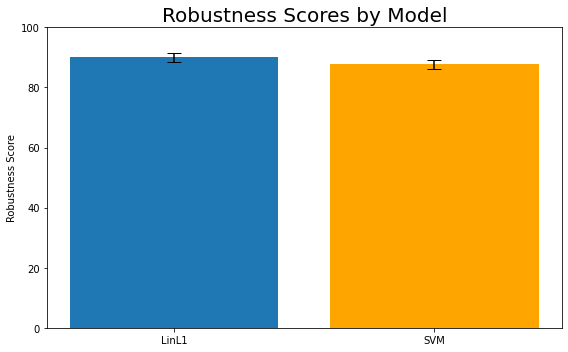

In [8]:
# Display the results of the robustness evaluation for both models
robustness_df = construct_scores_dataframe(scores("robustness", result))
display(robustness_df)

%matplotlib inline

def plot_robustness_scores():
    labels = ["LinL1", "SVM"]
    robustness_scores = robustness_df.iloc[:, 1].values
    lower_errors = robustness_scores - robustness_df.iloc[:, 2].values
    upper_errors = robustness_df.iloc[:, 3].values - robustness_scores
    x = np.arange(len(labels))

    fig, axs = plt.subplots(figsize=[8,5])
    axs.set_title("Robustness Scores by Model", fontsize=20)
    width = 0.8

    rect1 = axs.bar(x, robustness_scores, width, yerr=[lower_errors, upper_errors], capsize=7)
    rect1[1].set_color('orange')

    axs.set_ylim(top=100)
    axs.set_ylabel('Robustness Score')
    axs.set_xticks(x)
    axs.set_xticklabels(labels)

    fig.tight_layout()
    plt.show()
    
plot_robustness_scores()

,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
LinL1,LinL1,99.512195,98.780488,0.406504,0.813008,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SVM,SVM,97.183673,71.836735,0.000000,28.163265,0.0,0.0,0.0,0.0,0.0,0.0,0.0


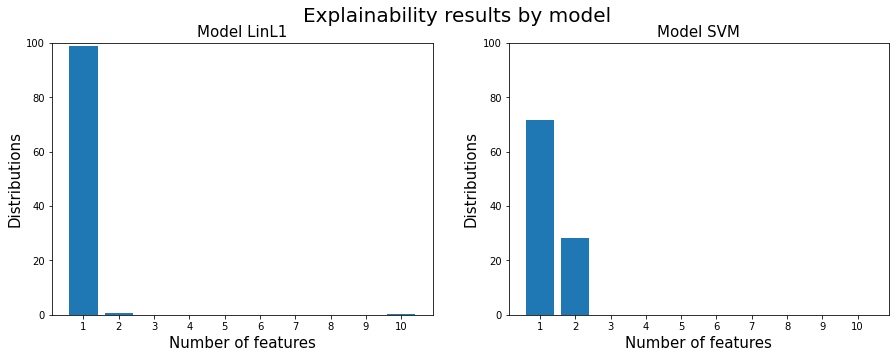

In [9]:
# Display the results of the explainability evaluation for both models
# The table displays the distributions over the number of features that must be changed to alter predictions
explainability_df = construct_scores_dataframe(scores("explainability", result))
display(explainability_df)

%matplotlib inline

def plot_histogram(axs, model_id):
    hist = result['explainability'][model_id]['explainability']['histogram']
    num_features = [x['num_features'] for x in hist]
    percentages = [x['percentage'] for x in hist]
    
    axs.bar(num_features, percentages)
    
    axs.set_xticks(num_features)
    axs.set_title(f"Model {model_id}", fontsize=15)
    axs.set_xlabel('Number of features', fontsize=15)
    axs.set_ylabel('Distributions', fontsize=15)
    
def plot_explainability_histograms():
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize=[15,5])
    fig.suptitle('Explainability results by model', fontsize=20)

    plot_histogram(axs1, "LinL1")
    plot_histogram(axs2, "SVM")

    axs1.set_ylim(top=100)
    axs2.set_ylim(top=100)
    
plot_explainability_histograms()

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (Gender),Feature (Gender) lower bound,Feature (Gender) upper bound,Group details (F),Group details (F) lower bound,...,Feature (Marital Status) upper bound,Group details (Divorced),Group details (Divorced) lower bound,Group details (Divorced) upper bound,Group details (Married),Group details (Married) lower bound,Group details (Married) upper bound,Group details (Single),Group details (Single) lower bound,Group details (Single) upper bound
LinL1 (burden),LinL1,burden,97.104818,95.218063,98.559318,98.007627,95.392739,99.799458,0.170482,0.165458,...,99.183312,0.170926,0.163486,0.177527,0.161631,0.154979,0.167712,0.168439,0.158080,0.177840
SVM (burden),SVM,burden,97.179941,95.046920,98.718894,97.485923,95.070680,99.552105,0.177651,0.173301,...,99.467315,0.176608,0.169744,0.182577,0.170151,0.164094,0.175338,0.172459,0.162272,0.181804


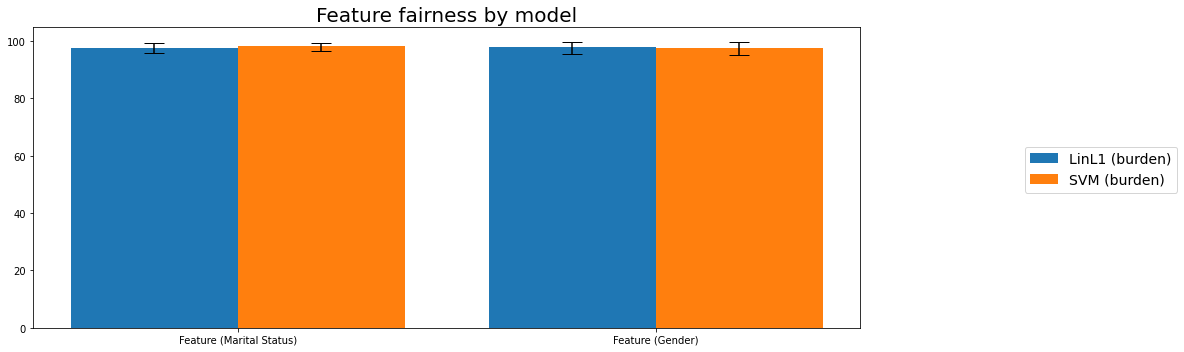

In [10]:
# Display the fairness results of fairness evaluation for both models
# The table displays the fairness scores across different groups within the "Marital Status" and "Gender" features. 
# You can set `include_confidence=True` to include confidence intervals for each burden value
fairness_df = construct_scores_dataframe(scores("fairness", result))
display(fairness_df)
print("\n")


%matplotlib inline

def plot_feature_fairness():
    features = ['Feature (Marital Status)', 'Feature (Gender)']
    feature_scores = fairness_df[features]
    feature_lower_bounds = fairness_df[[f + ' lower bound' for f in features]]
    feature_upper_bounds = fairness_df[[f + ' upper bound' for f in features]]

    fig, ax = plt.subplots(figsize=[15,5])
    ax.set_title('Feature fairness by model', fontsize=20)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
    width = 0.4

    ax.set_xticks(np.arange(len(features))+width)
    ax.set_xticklabels(features)

    for idx in range(len(fairness_df)):
        central_values = list(feature_scores.iloc[idx])
        lower_bounds = list(feature_lower_bounds.iloc[idx])
        upper_bounds = list(feature_upper_bounds.iloc[idx])
        lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
        upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

        ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
                central_values,
                width,
                yerr=[lower_errors, upper_errors],
                color=colors[idx],
                label=fairness_df.index[idx],
                capsize=10)

    fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
    fig.tight_layout()
    fig.subplots_adjust(right=0.8) 
    plt.show()
    
plot_feature_fairness()

In [11]:
# Below we will display the R-squared value computed during the performance evaluation
print('LinL1 R-squared: ', result['performance']['LinL1']['performance_metrics'][0]['value'])
print('SVM R-squared: ', result['performance']['SVM']['performance_metrics'][0]['value'])

LinL1 R-squared:  0.7630312169777798
SVM R-squared:  0.7458902350202914


In [12]:
# Using Certifai's explanation utilities we can programmatically explore counterfactuals produced
# during the explanation evaluation. Below we examine only a single explanation for each model
# by displaying the original input data followed by what features were changed by each
# counterfactual. Note, that for this regression use case a counterfactual will produced in the
# favorable direction (increasing) and in the unfavorable direction (decreasing)
linl1_explanations = explanations(result, 'LinL1')['LinL1']
svm_explanations = explanations(result, 'SVM')['SVM']

def display_explanation(expl):
    feature_names = np.array(expl.field_names)
    display(pd.DataFrame(np.expand_dims(expl.instance, axis=0), columns=feature_names))
    
    changed_features = []
    for cf in expl.explanation.best_individuals:
        cf_type = cf.counterfactual_type

        cf_changed_features = np.where(cf.data != expl.instance)[0]
        changed_features.extend(cf_changed_features.tolist())
        
    changed_features = np.array(list(set(changed_features)))

    data = [np.append(expl.instance[changed_features], expl.prediction)]
    cf_types = ["Original"]
    for cf in expl.explanation.best_individuals:
        cf_types.append(cf.counterfactual_type)
        
        row = np.append(cf.data[changed_features], cf.prediction)
        data.append(row)
    
    columns = np.append(feature_names[changed_features], "Prediction (Total Claim Amount)")
    feature_change_df = pd.DataFrame(data, columns=columns, index=cf_types)
    display(feature_change_df)
    print()

In [13]:
print("Explanations for LinL1 Model:\n")
display_explanation(linl1_explanations[0])  

Explanations for LinL1 Model:



,State Code,Claim Amount,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy,Claim Reason,Sales Channel,Vehicle Class,Vehicle Size
0,NE,387.365,Basic,College,Retired,M,28142,Suburban,Married,105,18,50,0,1,Personal L3,Hail,Agent,Sports Car,Medsize


,Monthly Premium Auto,Location Code,Prediction (Total Claim Amount)
Original,105,Suburban,539.653937
prediction increased,129,Suburban,658.882465
prediction decreased,105,Urban,383.221497


In [14]:
print("Explanations for SVM Model:\n")
display_explanation(linl1_explanations[1])

Explanations for SVM Model:



,State Code,Claim Amount,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy,Claim Reason,Sales Channel,Vehicle Class,Vehicle Size
0,IA,1212.84,Basic,College,Employed,F,20495,Suburban,Married,61,7,36,0,2,Personal L3,Hail,Agent,Four-Door Car,Medsize


,Monthly Premium Auto,Location Code,Prediction (Total Claim Amount)
Original,61,Suburban,330.852773
prediction increased,84,Suburban,449.058657
prediction decreased,61,Rural,-45.412334
